In [32]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import networkx as nx 

import matplotlib.pyplot as plt

from pyttn import ntree, ntreeNode
from operator import itemgetter


In [33]:
def gen_graph(M):
   return nx.from_numpy_array(np.abs(M - np.diag(np.diag(M))))

def split_high_degree_nodes(spanning_tree, N, max_degree=None):
   if max_degree is None:
      #if max degree has not been specified we just return the current tree
      return spanning_tree
   else:
      #in this case iterate through the tree determine if any nodes are too large and if they are we partition 
      #the node into sets of the correct size.  To do this we get a DFS edges list and if there are any instances
      #of nodes with more than max_degree children we insert sufficiently many logical nodes so that we have the
      #correct degree of connectivity
      edges = sorted([edge for edge in nx.dfs_edges(spanning_tree, source=0)], key = lambda x:x[0])
      print(edges)
      
      nchildren = {}
      nodes_to_split = {}

      curr_node = None
      sind = 0

      #iterate over the edges getting the number of children associated with each node and the location of the
      #first edge associated with a nodes children in the list
      for i, e in enumerate(edges):
         if curr_node != e[0]:
            curr_node = e[0]
            sind = i

         if e[0] not in nchildren.keys():
            nchildren[e[0]]=1
         else:
            nchildren[e[0]]+=1

         if nchildren[e[0]] > max_degree:
            if e[0] not in nodes_to_split.keys():
               nodes_to_split[e[0]]=sind
               
      #if none of the nodes are high degree we don't need to do anything
      if len(nodes_to_split) == 0:
         return spanning_tree
      
      #otherwise we iterate through the tree and split high degree nodes off
      else:
         #now we split any nodes that need to be split
         counter = N
         T = nx.Graph()
         #if we are at a node we need to split
         for node, ind in nodes_to_split.items():
            nchild = nchildren[node]

            #insert floor(nchild/max_degree) logical nodes that will be full connecting 
            for j in range(nchild//max_degree):
               T.add_edge(node, counter)
               for k in range(max_degree):
                  T.add_edge(counter, edges[ind+j*max_degree+k][1])

               counter = counter+1

            if nchild%max_degree == 1:
               for j in range( (nchild//max_degree)*max_degree, nchild):
                  T.add_edge(node,  edges[ind+j][1])

            elif nchild%max_degree > 1:
               T.add_edge(node, counter)

               for k in range((nchild//max_degree)*max_degree, nchild):
                  T.add_edge(counter, edges[ind+j][1])

               counter = counter+1

         for e in edges:
            if e[0] not in nodes_to_split.keys():
               T.add_edge(e[0], e[1])
         return T

def insert_physical_nodes(spanning_tree, N):
   nindex = spanning_tree.number_of_nodes()

   mapping = {}
   for i in range(N):
      mapping[i] = nindex+i

   #iterate over the tree and add nodes to any n
   nx.relabel_nodes(spanning_tree, mapping=mapping, copy=False)

   for i in range(N):
      spanning_tree.add_edge(nindex+i, i)

   return spanning_tree, nindex

def generate_spanning_tree(M, max_degree=None):
   G = gen_graph(M)

   spanning_tree = nx.maximum_spanning_tree(G)
   spanning_tree = split_high_degree_nodes(spanning_tree, M.shape[0], max_degree=max_degree)

   return insert_physical_nodes(spanning_tree, M.shape[0])

def generate_dendrogram(M):
   G = gen_graph(M)
   def heaviest(G):
      u, v, w = max(G.edges(data="weight"), key=itemgetter(2))      
      return u,v 

   #to do swap this out for a better clustering algorithm
   comp = nx.community.girvan_newman(G, most_valuable_edge=heaviest)

   #now that we have got all of the communities lets build networkx trees representing this hierarchical
   #clustering
   T = nx.Graph()

   node_list = []
   for c in reversed(list(comp)):
      for x in c:
         if x not in node_list:
            node_list.append(x)
   node_list.append(set([x for x in range(M.shape[0])]))

   edges = []

   for i in range(len(node_list)):
      find_parent = True
      for j in range(i+1, len(node_list)):
         if(node_list[i].issubset(node_list[j])) and find_parent:
            edges.append((i, j))
            find_parent = False

   for e in edges:
      T.add_edge(e[1], e[0])
      T.add_edge(e[0], e[1])
   
   return T, len(node_list)-1

def convert_nx_to_subtree(spanning_tree, root, root_ind=0):
   root_skip = root.size()
   node_dict = {root_ind: [root_skip]}
   edge_counter = {}

   node_inserted = False  
   for edge in nx.dfs_edges(spanning_tree, source=root_ind):
      #if this is the first edge in the dfs list then we need to insert both nodes
      #so first insert left most node
      if not node_inserted:
         root.at([]).insert(edge[0])
         node_inserted = True

      if edge[0] not in edge_counter.keys():
         edge_counter[edge[0]] = 0
      else:
         edge_counter[edge[0]] += 1

      node_dict[edge[1]] = node_dict[edge[0]] + [edge_counter[edge[0]]]
      root.at(node_dict[edge[0]]).insert(edge[1])


def convert_nx_to_tree(spanning_tree, root_ind=0):
   tree = ntree(str(spanning_tree.number_of_nodes()))

   node_dict = {root_ind: []}
   edge_counter = {}

   for edge in nx.dfs_edges(spanning_tree, source=root_ind):

      if edge[0] not in edge_counter.keys():
         edge_counter[edge[0]] = 0
      else:
         edge_counter[edge[0]] += 1

      node_dict[edge[1]] = node_dict[edge[0]] + [edge_counter[edge[0]]]
      tree().at(node_dict[edge[0]]).insert(edge[1])

   return tree


def __get_value(chi, level):
   if isinstance(chi, (list, np.ndarray)):
      return chi[level]
   elif callable(chi):
      return chi(level)
   else:
      return chi


def __setup_bond_properties_internal(node, chi, dims, level, chi_local_transform):
   if node.is_leaf():
      node.value = dims[node.value]
   elif node.is_root():
      node.value = 1
   elif node.is_local_basis_transformation():
      chiv = __get_value(chi_local_transform, node.at(0).value)
      if chiv is None:
         chiv = __get_value(chi, level)
      node.value = chiv
   else:
      node.value = __get_value(chi, level)

   for i in range(node.size()):
      __setup_bond_properties_internal(node.at(i), chi, dims, level+1, chi_local_transform)

def setup_bond_properties(root, chi, dims, chi_local_transform=None):
   if isinstance(root, ntree):
      __setup_bond_properties_internal(root(), chi, dims, 0, chi_local_transform)
   elif isinstance(root, ntreeNode):
      __setup_bond_properties_internal(root, chi, dims, 0, chi_local_transform)

/tmp/ipykernel_682/3977131510.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i, (i+1)%(N+1)] += 5*np.random.uniform(0, 1, size=1)+6
/tmp/ipykernel_682/3977131510.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[(i+1)%(N+1), i] += 5*np.random.uniform(0, 1, size=1)+6


[(0, 1), (0, 32), (1, 2), (2, 3), (3, 4), (4, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31)]


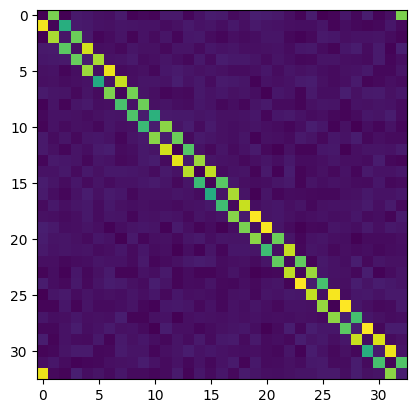

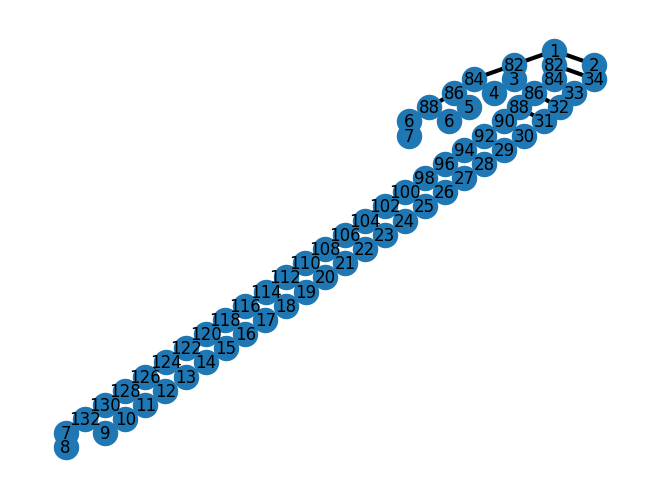

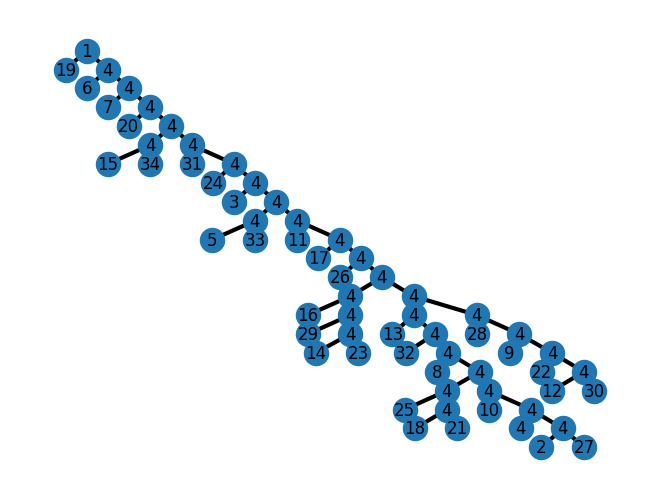

In [34]:
from pyttn.utils import visualise_tree

   

tree = ntree("(0(121))")
tree2 = ntree("(0(121))")

N=32

v = np.random.uniform(0, 1, size=N)
w = np.random.uniform(0, 1, size=(N,N))
w = (w + w.T)/2.0
gamma = np.zeros((N+1, N+1))
gamma[0, 1:] = v
gamma[1:, 0] = v
gamma[1:, 1:] = w
for i in range(N):

   gamma[i, (i+1)%(N+1)] += 5*np.random.uniform(0, 1, size=1)+6
   gamma[(i+1)%(N+1), i] += 5*np.random.uniform(0, 1, size=1)+6


def chi_func(level):
   return (level+40)*2

plt.figure(1)
plt.imshow(gamma)

spanning_tree, spanning_root_ind = generate_spanning_tree(gamma, max_degree=2)
dendromer_tree, root_ind = generate_dendrogram(gamma)

tree = convert_nx_to_tree(spanning_tree, root_ind=spanning_root_ind)
tree2 = convert_nx_to_tree(dendromer_tree, root_ind=root_ind)

setup_bond_properties(tree, chi_func, [2+x for x in range(N+1)], chi_local_transform = [1+x for x in range(N+1)])
setup_bond_properties(tree2, 4, [2+x for x in range(N+1)], chi_local_transform = [1+x for x in range(N+1)])

plt.figure(2)
visualise_tree(tree)

plt.figure(3)
visualise_tree(tree2)